In [1]:
import collections
from functools import partial
import itertools
import json
import pathlib
import sys

from jax import tree_util
import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import infer
import main
import metrics
import progmet

In [2]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file'])

def standard_experiment(experiment_dir, epoch):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
    )

In [3]:
device = torch.device('cuda')

In [4]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, _, _, _, eval_label_map = main.make_datasets(base_config)

In [5]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [6]:
results = {}

In [86]:
experiments = {
    'flat': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d7_n2_i0_c/',
        epoch=20),
    'descendant': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax-bal/',
        epoch=20),
    'sibling': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax_complement-bal/',
        epoch=20),
    'hier-old': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-11-inat21mini-partition/d7_n2_i0_c-hier/',
        epoch=20),
    'flat-old': standard_experiment(
        experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-11-inat21mini-partition/d7_n2_i0_c/',
        epoch=20),
}
hierarchy_files = {
    'full': 'resources/hierarchy/inat21.csv',
    'train': 'resources/subtree/inat21_partition_d7_n2_i0_c.csv',
    'trunc': 'resources/subtree/inat21_max_depth_6.csv',
}

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d6_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_5.csv',
# }

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d4_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_3.csv',
# }

In [87]:
trees = {}
node_names = {}

for tree_name, hierarchy_file in hierarchy_files.items():
    with open(hierarchy_file) as f:
        trees[tree_name], node_names[tree_name] = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [88]:
# Precompute some things and define functions for each tree.

metric_fns = {}
infer_fns = {}
specificity = {}
is_leaf = {}
not_trivial = {}

for tree_name, tree in trees.items():
    info_metric = metrics.UniformLeafInfoMetric(tree)
    depth_metric = metrics.DepthMetric(tree)
    metric_fns[tree_name] = {
        'exact': lambda gt, pr: pr == gt,
        'correct': metrics.IsCorrect(tree),
        'info_excess': info_metric.excess,
        'info_deficient': info_metric.deficient,
        'info_dist': info_metric.dist,
        'info_recall': info_metric.recall,
        'info_precision': info_metric.precision,
        'depth_excess': depth_metric.excess,
        'depth_deficient': depth_metric.deficient,
        'depth_dist': depth_metric.dist,
        'depth_recall': depth_metric.recall,
        'depth_precision': depth_metric.precision,
    }

    is_leaf[tree_name] = tree.leaf_mask()
    specificity[tree_name] = -tree.num_leaf_descendants()
    not_trivial[tree_name] = (tree.num_children() != 1)

    infer_fns[tree_name] = {
        'leaf': partial(
            infer.argmax_where, condition=is_leaf[tree_name]),
        'majority': partial(
            infer.argmax_with_confidence, specificity[tree_name],
            threshold=0.5, condition=not_trivial[tree_name]),
    }

In [89]:
node_subsets = {}
for tree_name in trees:
    node_subsets[tree_name] = hier.find_subset_index(node_names['full'], node_names[tree_name])
node_subsets

{'full': array([    0,     1,     2, ..., 16341, 16342, 16343]),
 'train': array([    0,     1,     2, ..., 16335, 16336, 16337]),
 'trunc': array([    0,     1,     2, ..., 16340, 16341, 16342])}

In [90]:
def apply_model(net, pred_fn, min_threshold):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {tree_name: {method: [] for method in infer_fns[tree_name]} for tree_name in trees},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': {tree_name: [] for tree_name in trees},
        'prob': {tree_name: [] for tree_name in trees},
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in meter(eval_loader):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            # Get distribution on training subtree.
            prob = {}
            prob['train'] = pred_fn(theta).cpu().numpy()
            # Get distribution on full subtree (pad with zeros).
            prob['full'] = np.zeros((inputs.shape[0], trees['full'].num_nodes()), dtype=np.float32)
            prob['full'][:, node_subsets['train']] = prob['train']
            # Get distribution on truncated subtree.
            prob['trunc'] = prob['full'][..., node_subsets['trunc']]

            gt_node = eval_label_map.to_node[gt_labels]
            # Caution: Predictions are *not* truncated.
            pred = {}
            pred_seqs = {}
            prob_seqs = {}
            for tree_name in trees:
                pred[tree_name] = {}
                for infer_name, infer_fn in infer_fns[tree_name].items():
                    pred[tree_name][infer_name] = infer_fn(prob[tree_name])
                pred_seqs[tree_name] = [
                    infer.pareto_optimal_predictions(
                        specificity[tree_name], p, min_threshold, not_trivial[tree_name])
                    for p in prob[tree_name]
                ]
                prob_seqs[tree_name] = [prob[tree_name][i, pred_i] for i, pred_i in enumerate(pred_seqs[tree_name])]

            outputs['gt'].append(gt_node)
            for tree_name in trees:
                for method in infer_fns[tree_name]:
                    outputs['pred'][tree_name][method].append(pred[tree_name][method])
                seq_outputs['pred'][tree_name].extend(pred_seqs[tree_name])
                seq_outputs['prob'][tree_name].extend(prob_seqs[tree_name])

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [91]:
def assess_predictions(outputs, seq_outputs):
    pred_metrics = {}
    pareto_scores = {}
    pareto_means = {}

    # Evaluate predictions for each method and for each subset of examples.
    for tree_name in outputs['pred'].keys():
        tree = trees[tree_name]
        project = hier.find_projection(trees['full'], node_subsets[tree_name])
        gt = project[outputs['gt']]
        pred = outputs['pred'][tree_name]
        pred_seq = seq_outputs['pred'][tree_name]
        prob_seq = seq_outputs['prob'][tree_name]
        pred = {
            method: hier.truncate_at_lca(tree, gt, pr)
            for method, pr in pred.items()
        }
        pred_metrics[tree_name] = {
            method: {
                field: np.mean(metric_fn(gt, pr))
                for field, metric_fn in metric_fns[tree_name].items()
            } for method, pr in pred.items()
        }

        # Evaluate predictions in Pareto sequence.
        find_lca = hier.FindLCA(tree)
        pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
        metric_values_seq = {
            field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
            for field, metric_fn in metric_fns[tree_name].items()
        }
        pareto_scores[tree_name], pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
        pareto_means[tree_name] = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [92]:
MIN_THRESHOLD = 0.2  # Values less than 0.5 may increase runtime significantly.

for name, (config_file, model_file) in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, trees['train'])
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, trees['train'], device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD)

    example_masks = {
        'seen': np.isin(outputs['gt'], node_subsets['train']),
        'unseen': np.isin(outputs['gt'], node_subsets['train'], invert=True),
        'all': None,
    }

    pred_metrics = {}
    pareto_scores = {}
    pareto_metrics = {}
    for subset_name, example_mask in example_masks.items():
        print('evaluate:', subset_name, file=sys.stderr)
        if example_mask is None:
            subset_outputs = outputs
            subset_seq_outputs = seq_outputs
        else:
            example_subset, = np.nonzero(example_mask)
            subset_outputs = tree_util.tree_map(lambda x: x[example_mask], outputs)
            subset_seq_outputs = {
                'pred': {tree_name: [seq_outputs['pred'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['pred']},
                'prob': {tree_name: [seq_outputs['prob'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['prob']},
            }
        pred_metrics[subset_name], pareto_scores[subset_name], pareto_metrics[subset_name] = (
            assess_predictions(subset_outputs, subset_seq_outputs))

    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

cached: flat
cached: descendant
cached: sibling


apply:   1% (3/391); T=1.70 f=0.588; mean T=1.70 f=0.588; elapsed 0:00:05; remaining 0:11:00 of 0:11:05
apply:   3% (11/391); T=0.639 f=1.56; mean T=0.929 f=1.08; elapsed 0:00:10; remaining 0:05:53 of 0:06:03
apply:   5% (19/391); T=0.629 f=1.59; mean T=0.802 f=1.25; elapsed 0:00:15; remaining 0:04:59 of 0:05:14
apply:   7% (28/391); T=0.615 f=1.62; mean T=0.742 f=1.35; elapsed 0:00:21; remaining 0:04:29 of 0:04:50
apply:   9% (36/391); T=0.626 f=1.60; mean T=0.717 f=1.40; elapsed 0:00:26; remaining 0:04:14 of 0:04:40
apply:  12% (45/391); T=0.620 f=1.61; mean T=0.697 f=1.43; elapsed 0:00:31; remaining 0:04:01 of 0:04:33
apply:  14% (54/391); T=0.622 f=1.61; mean T=0.685 f=1.46; elapsed 0:00:37; remaining 0:03:51 of 0:04:28
apply:  16% (63/391); T=0.624 f=1.60; mean T=0.676 f=1.48; elapsed 0:00:43; remaining 0:03:42 of 0:04:24
apply:  18% (72/391); T=0.608 f=1.64; mean T=0.668 f=1.50; elapsed 0:00:48; remaining 0:03:33 of 0:04:21
apply:  21% (81/391); T=0.624 f=1.60; mean T=0.663 f=1.5

In [94]:
# Majority prediction in full tree.
# Rewards method for not being too confident about leaf nodes.
# However, this was not something that was represented in the objective?
# It's ok to use though.. just need to plot curves!

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                     info_recall                    
                all      seen    unseen         all      seen    unseen
flat        0.72593  0.840825  0.610159    0.463172  0.594218  0.331127
descendant  0.78242  0.857900  0.706364    0.420240  0.513514  0.326254
sibling     0.77258  0.857362  0.687151    0.434420  0.532132  0.335963

In [95]:
# Majority prediction in truncated tree.

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['trunc']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                     info_recall                    
                all      seen    unseen         all      seen    unseen
flat        0.77552  0.854931  0.695503    0.504683  0.625930  0.382512
descendant  0.78338  0.856286  0.709918    0.490281  0.605935  0.373745
sibling     0.77177  0.854274  0.688637    0.505961  0.626203  0.384803

In [96]:
# Majority prediction in training tree.

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['train']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                     info_recall                    
                all      seen    unseen         all      seen    unseen
flat        0.78528  0.840825  0.729311    0.529767  0.609051  0.449878
descendant  0.81082  0.863180  0.758061    0.471622  0.510890  0.432055
sibling     0.80516  0.863379  0.746497    0.486008  0.528535  0.443156

In [97]:
# Leaf prediction in full tree.

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['leaf'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                  info_recall                    
                all      seen unseen         all      seen    unseen
flat        0.28748  0.572783    0.0    0.550828  0.709632  0.390813
descendant  0.28338  0.564614    0.0    0.548152  0.704876  0.390231
sibling     0.28648  0.570791    0.0    0.549734  0.708045  0.390215

In [98]:
markers = {
    'leaf': 's',
    'majority': 'o',
}

colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [99]:
[list(experiments.keys())]def plot_metrics(tree_name, subset_name, x, y):
    for name in results:
        pred_metrics = results[name]['pred_metrics'][subset_name][tree_name]
        pareto_scores = results[name]['pareto_scores'][subset_name][tree_name]
        pareto_metrics = results[name]['pareto_metrics'][subset_name][tree_name]
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=name)
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], linestyle='--')
        for method, method_metrics in pred_metrics.items():
            plt.plot(method_metrics[x], method_metrics[y], color=colors[name],
                     marker=markers[method], markerfacecolor='none')
    plt.ylim(top=1)
    plt.xlim(left=0)
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

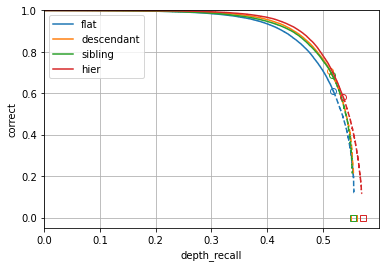

In [100]:
# Plot trade-off for unseen examples in full tree, where either method can predict leaf nodes.
plot_metrics('full', 'unseen', 'depth_recall', 'correct')

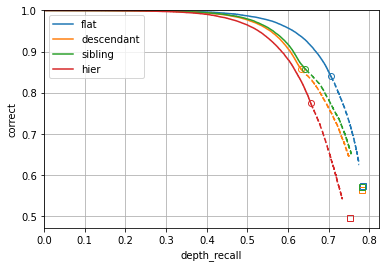

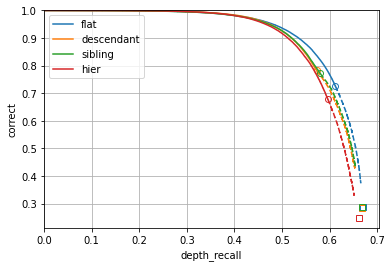

In [101]:
# Check whether the accuracy on the "seen" examples overwhelm the "unseen".
plot_metrics('full', 'seen', 'depth_recall', 'correct')
plt.show()
plot_metrics('full', 'all', 'depth_recall', 'correct')

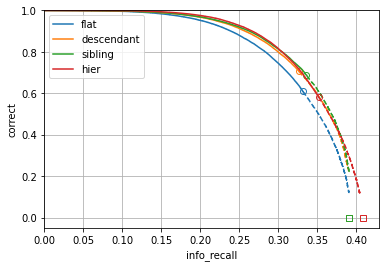

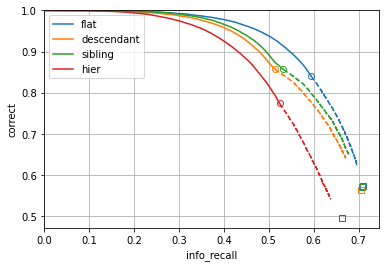

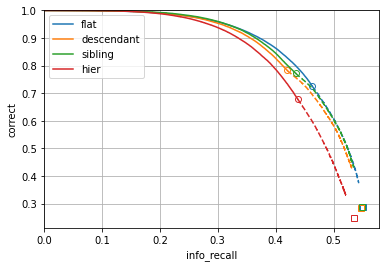

In [109]:
# Look at same plots for information.

plot_metrics('full', 'unseen', 'info_recall', 'correct')
plt.show()
plot_metrics('full', 'seen', 'info_recall', 'correct')
plt.show()
plot_metrics('full', 'all', 'info_recall', 'correct')

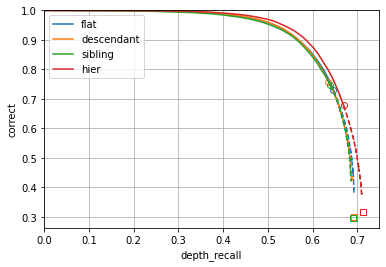

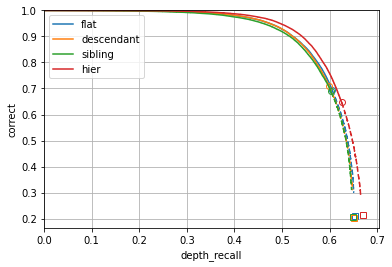

In [103]:
# Check the trade-off for unseen examples using metrics in the "train" and "trunc" subtrees.
# These give no penalty for predicting a leaf node under the nearest projected ancestor.
# (In fact, the prediction will be truncated at the ground-truth.)

plot_metrics('train', 'unseen', 'depth_recall', 'correct')
plt.show()
plot_metrics('trunc', 'unseen', 'depth_recall', 'correct')

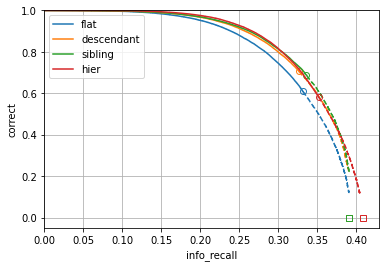

In [104]:
# Check that it holds for info-recall.
plot_metrics('full', 'unseen', 'info_recall', 'correct')

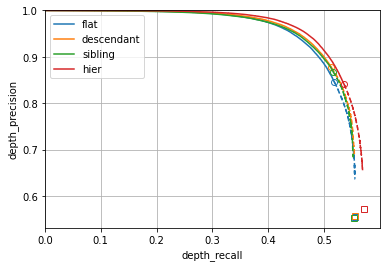

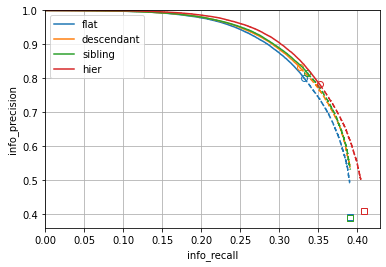

In [105]:
# Check that it holds for recall-precision.
plot_metrics('full', 'unseen', 'depth_recall', 'depth_precision')
plt.show()
plot_metrics('full', 'unseen', 'info_recall', 'info_precision')

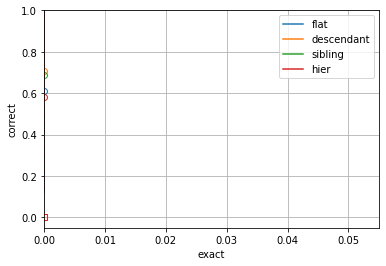

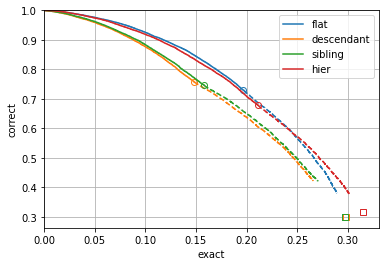

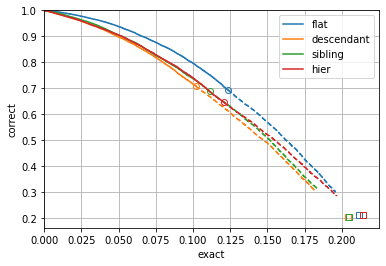

In [106]:
# Cannot plot correct-exact for unseen classes in full tree -- none will be exact.
# See how it looks in train/trunc trees.
# This requires the algorithm to predict the projected node, not a descendant.

plot_metrics('full', 'unseen', 'exact', 'correct')
plt.show()
plot_metrics('train', 'unseen', 'exact', 'correct')
plt.show()
plot_metrics('trunc', 'unseen', 'exact', 'correct')

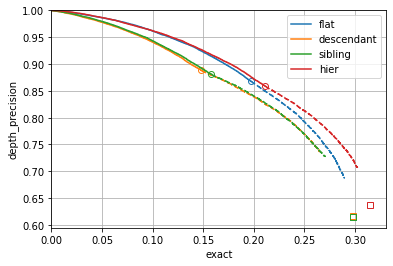

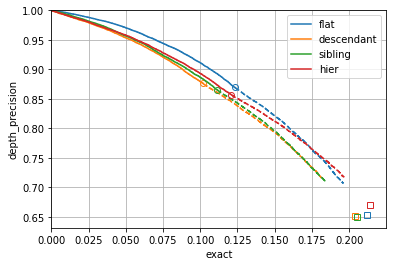

In [107]:
# Try with precision instead of binary correct.
plot_metrics('train', 'unseen', 'exact', 'depth_precision')
plt.show();
plot_metrics('trunc', 'unseen', 'exact', 'depth_precision')

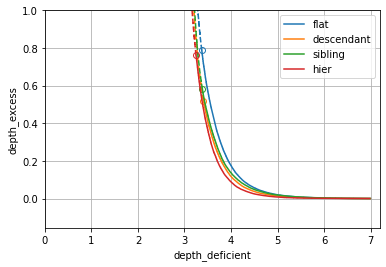

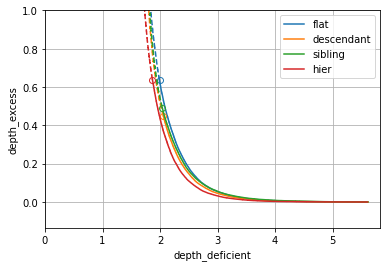

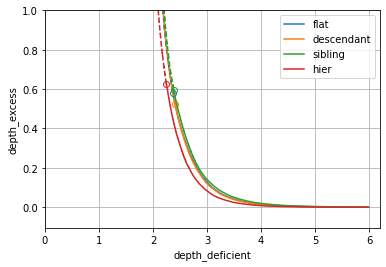

In [108]:
plot_metrics('full', 'unseen', 'depth_deficient', 'depth_excess')
plt.show()
plot_metrics('train', 'unseen', 'depth_deficient', 'depth_excess')
plt.show()
plot_metrics('trunc', 'unseen', 'depth_deficient', 'depth_excess')